# # Dataset-4 Phishing Email

# Exploration

In [7]:
import numpy as np
import pandas as pd
import re
from scipy import stats as sps
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, Latex

file_path = 'Phishing_Email.csv'

# Load the data
data = pd.read_csv(file_path)

# Number of samples and raw features
num_samples = data.shape[0]
num_features = data.shape[1]
print(f"Number of samples: {num_samples}")
print(f"Number of raw features: {num_features}")

# Fraction of missing values
missing_values = data.isnull().sum() / num_samples
fraction_missing = missing_values[missing_values > 0]
if fraction_missing.empty:
    print("No missing values in the dataset.")
else:
    print("Fraction of missing values per column:")
    print(fraction_missing)


Number of samples: 18650
Number of raw features: 3
Fraction of missing values per column:
Email Text    0.000858
dtype: float64


There is only 1 categorical column whic is also the target variable: Email Type

,Unnamed: 0,Email Text,Email Type,email_length,cleaned_text,label
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,1030,"re : 6 . 1100 , disc : uniformitarianism , re ...",0
1,1,the other side of * galicismos * * galicismo *...,Safe Email,479,the other side of * galicismos * * galicismo *...,0
2,2,re : equistar deal tickets are you still avail...,Safe Email,1245,re : equistar deal tickets are you still avail...,0
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email,688,Hello I am your hot lil horny toy. I am the on...,1
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email,441,software at incredibly low prices ( 86 % lower...,1


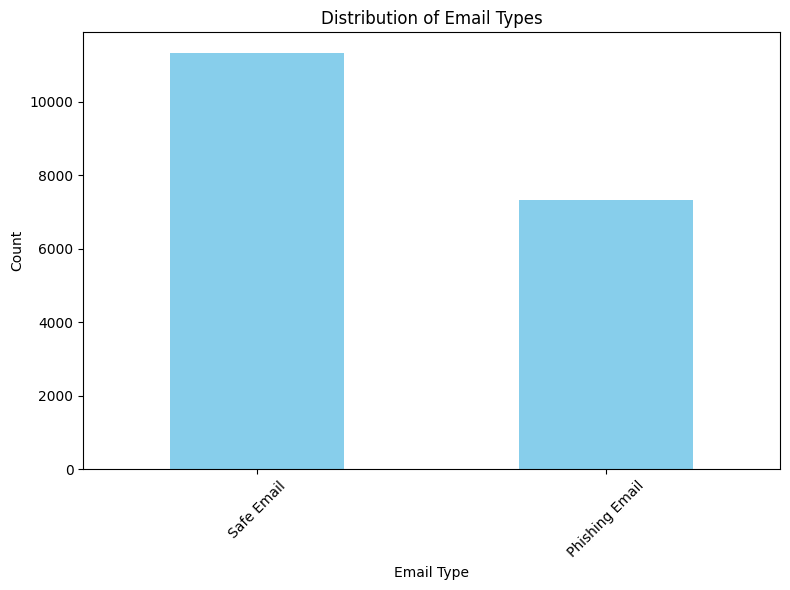

In [14]:
display(data.head())

plt.figure(figsize=(8, 6))
data['Email Type'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Email Types')
plt.xlabel('Email Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [ ]:
# (b) Preprocessing of the Dataset

# We'll do a simple text preprocessing:
# - Remove URLs and Extra Spaces for a cleaner text representation



def preprocess_text(text):
    if not isinstance(text, str):
        text = str(text)
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Replace multiple whitespaces with a single space
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply the revised preprocessing
data['cleaned_text'] = data['Email Text'].apply(preprocess_text)
data['label'] = data['Email Type'].map({'Safe Email':0, 'Phishing Email':1})


# Check a few examples
display(data[['Email Text', 'cleaned_text', 'Email Type', 'label']].head())



,Email Text,cleaned_text,Email Type,label
0,"re : 6 . 1100 , disc : uniformitarianism , re ...","re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,0
1,the other side of * galicismos * * galicismo *...,the other side of * galicismos * * galicismo *...,Safe Email,0
2,re : equistar deal tickets are you still avail...,re : equistar deal tickets are you still avail...,Safe Email,0
3,\nHello I am your hot lil horny toy.\n I am...,Hello I am your hot lil horny toy. I am the on...,Phishing Email,1
4,software at incredibly low prices ( 86 % lower...,software at incredibly low prices ( 86 % lower...,Phishing Email,1


In [ ]:
# (c) Feature Extraction 
# We'll create a vocabulary from the training set. For simplicity, we won't limit to top features here,
# but we could. We'll do it after we split the data into training and test sets to simulate a realistic scenario.

def train_test_split_custom(X, y, test_size=0.2, random_state=42):
    np.random.seed(random_state)
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    split_idx = int(len(X)* (1 - test_size))
    train_idx, test_idx = indices[:split_idx], indices[split_idx:]
    return train_idx, test_idx

X_all = data['cleaned_text'].values
y_all = data['label'].values

train_idx, test_idx = train_test_split_custom(X_all, y_all, test_size=0.2, random_state=42)
X_train_raw, X_test_raw = X_all[train_idx], X_all[test_idx]
y_train, y_test = y_all[train_idx], y_all[test_idx]

def build_vocab(docs, min_count=1):
    vocab_freq = {}
    for doc in docs:
        for word in doc.split():
            vocab_freq[word] = vocab_freq.get(word, 0) + 1
    # We can filter words by min_count if desired
    vocab = [w for w, c in vocab_freq.items() if c >= min_count]
    vocab = sorted(vocab)
    word2idx = {w: i for i, w in enumerate(vocab)}
    return vocab, word2idx

vocab, word2idx = build_vocab(X_train_raw, min_count=2)  # filter very rare words
print(f"Vocabulary size: {len(vocab)}")

def docs_to_term_matrix(docs, word2idx):
    # Create a bag-of-words term matrix
    mat = np.zeros((len(docs), len(word2idx)), dtype=np.float32)
    for i, doc in enumerate(docs):
        words = doc.split()
        for w in words:
            if w in word2idx:
                mat[i, word2idx[w]] += 1.0
    return mat

X_train_counts = docs_to_term_matrix(X_train_raw, word2idx)
X_test_counts = docs_to_term_matrix(X_test_raw, word2idx)

# Compute IDF
def compute_idf(matrix):
    # IDF: log(N/df) where df is doc freq
    N = matrix.shape[0]
    df = np.count_nonzero(matrix, axis=0)
    idf = np.log((N+1)/(df+1)) + 1
    return idf

idf = compute_idf(X_train_counts)

def tfidf_transform(count_matrix, idf):
    # tf = count / sum_of_counts_in_doc
    tfidf = np.zeros_like(count_matrix, dtype=np.float32)
    sums = np.sum(count_matrix, axis=1, keepdims=True)
    sums[sums == 0] = 1.0
    tf = count_matrix / sums
    tfidf = tf * idf
    return tfidf

X_train = tfidf_transform(X_train_counts, idf)
X_test = tfidf_transform(X_test_counts, idf)


Vocabulary size: 101617


Reduced vocabulary size: 5000
Best NB Params: {'alpha': 0.1} CV Score: 0.941621983914209
Best LR Params: {'lr': 0.1, 'max_iter': 100, 'C': 10.0} CV Score: 0.6104557640750671
--- Naive Bayes Performance ---
Accuracy:  0.9424
Precision: 0.9504
Recall:    0.8986
F1-score:  0.9237

--- Logistic Regression Performance ---
Accuracy:  0.6201
Precision: 0.6404
Recall:    0.0504
F1-score:  0.0934



C:\Users\ethan\AppData\Local\Temp\ipykernel_24128\985331101.py:210: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['','Safe','Phishing'])
C:\Users\ethan\AppData\Local\Temp\ipykernel_24128\985331101.py:211: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['','Safe','Phishing'])


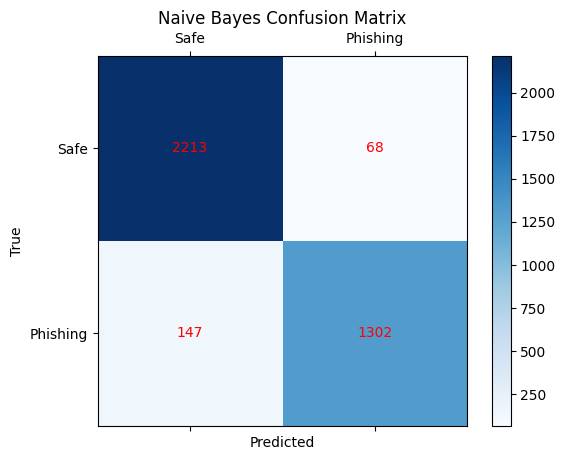

C:\Users\ethan\AppData\Local\Temp\ipykernel_24128\985331101.py:210: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['','Safe','Phishing'])
C:\Users\ethan\AppData\Local\Temp\ipykernel_24128\985331101.py:211: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['','Safe','Phishing'])


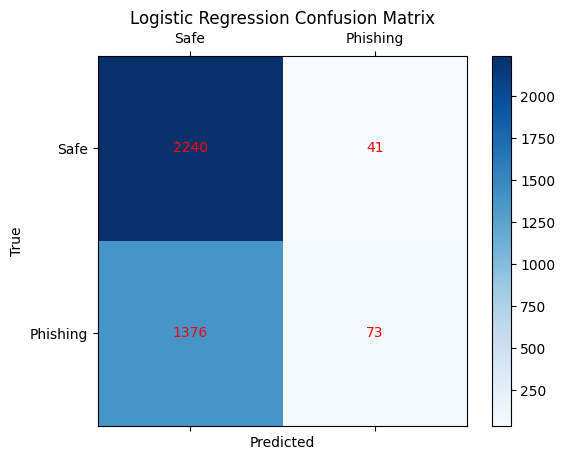

In [12]:
# Reducing Vocabulary so not to overload gpu / computer this could also theoretically be considered preprocessing
def build_vocab(docs, min_count=5, max_features=5000):
    vocab_freq = {}
    for doc in docs:
        words = doc.split()
        for w in words:
            vocab_freq[w] = vocab_freq.get(w, 0) + 1

    # Filter words by min_count
    filtered = [(w,c) for w,c in vocab_freq.items() if c >= min_count]

    # Sort by frequency (descending)
    filtered.sort(key=lambda x: x[1], reverse=True)

    # Keep top max_features words
    filtered = filtered[:max_features]

    vocab = [w for w,_ in filtered]
    vocab = sorted(vocab)
    word2idx = {w: i for i, w in enumerate(vocab)}
    return vocab, word2idx

# Assume X_train_raw, X_test_raw, y_train, y_test are already defined
vocab, word2idx = build_vocab(X_train_raw, min_count=5, max_features=5000)
print(f"Reduced vocabulary size: {len(vocab)}")

def docs_to_term_matrix(docs, word2idx):
    mat = np.zeros((len(docs), len(word2idx)), dtype=np.float32)
    for i, doc in enumerate(docs):
        words = doc.split()
        for w in words:
            if w in word2idx:
                mat[i, word2idx[w]] += 1.0
    return mat

X_train_counts = docs_to_term_matrix(X_train_raw, word2idx)
X_test_counts = docs_to_term_matrix(X_test_raw, word2idx)

def compute_idf(matrix):
    N = matrix.shape[0]
    df = np.count_nonzero(matrix, axis=0)
    idf = np.log((N+1)/(df+1)) + 1
    return idf

idf = compute_idf(X_train_counts)

def tfidf_transform(count_matrix, idf):
    sums = np.sum(count_matrix, axis=1, keepdims=True)
    sums[sums == 0] = 1.0
    tf = count_matrix / sums
    return tf * idf

X_train = tfidf_transform(X_train_counts, idf)
X_test = tfidf_transform(X_test_counts, idf)


# (d) Two Different ML Methods:
# Implementing Naive Bayes and Logistic Regression f
# With k-fold cross-validation

#Naive Bayes
class NaiveBayesClassifier:
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.priors = np.zeros(len(self.classes))
        self.word_counts = np.zeros((len(self.classes), X.shape[1]))
        self.class_counts = np.zeros(len(self.classes))
        
        for c in self.classes:
            X_c = X[y == c]
            self.class_counts[c] = X_c.shape[0]
            self.word_counts[c, :] = np.sum(X_c, axis=0)
        
        self.priors = self.class_counts / np.sum(self.class_counts)
        self.total_counts = np.sum(self.word_counts, axis=1) + self.alpha*X.shape[1]
        
    def predict(self, X):
        preds = []
        for i in range(X.shape[0]):
            posteriors = []
            for c in self.classes:
                logp = np.log(self.priors[c])
                word_probs = (self.word_counts[c] + self.alpha)/self.total_counts[c]
                logp += np.sum(X[i] * np.log(word_probs+1e-15))
                posteriors.append(logp)
            preds.append(np.argmax(posteriors))
        return np.array(preds)

#Logistic Regression
class LogisticRegressionGD:
    def __init__(self, lr=0.1, max_iter=100, C=1.0):
        self.lr = lr
        self.max_iter = max_iter
        self.C = C  # regularization strength, L2
        
    def sigmoid(self, z):
        return 1/(1+np.exp(-z))
    
    def fit(self, X, y):
        N, D = X.shape
        self.w = np.zeros(D)
        self.b = 0.0
        
        for _ in range(self.max_iter):
            z = X @ self.w + self.b
            p = self.sigmoid(z)
            grad_w = (X.T @ (p - y))/N + (1/self.C)*self.w
            grad_b = np.mean(p - y)
            self.w -= self.lr * grad_w
            self.b -= self.lr * grad_b
            
    def predict(self, X):
        z = X @ self.w + self.b
        p = self.sigmoid(z)
        return (p >= 0.5).astype(int)

# Implement k-fold cross-validation
def k_fold_split(X, y, k=5, seed=42):
    np.random.seed(seed)
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    folds = np.array_split(indices, k)
    return folds

def cross_val_score_model(model_class, X, y, param_grid, k=5):
    best_score = -1
    best_params = None
    folds = k_fold_split(X, y, k)
    
    for params in param_grid:
        scores = []
        for i in range(k):
            val_idx = folds[i]
            train_idx = np.concatenate([folds[j] for j in range(k) if j!=i])
            X_train_cv, X_val_cv = X[train_idx], X[val_idx]
            y_train_cv, y_val_cv = y[train_idx], y[val_idx]
            
            model = model_class(**params)
            model.fit(X_train_cv, y_train_cv)
            preds = model.predict(X_val_cv)
            acc = np.mean(preds == y_val_cv)
            scores.append(acc)
        avg_score = np.mean(scores)
        if avg_score > best_score:
            best_score = avg_score
            best_params = params
    return best_params, best_score

# Tune Naive Bayes
nb_params, nb_score = cross_val_score_model(NaiveBayesClassifier, X_train, y_train, 
                                            [{'alpha':0.1}, {'alpha':0.5}, {'alpha':1.0}], k=5)
print("Best NB Params:", nb_params, "CV Score:", nb_score)

best_nb = NaiveBayesClassifier(**nb_params)
best_nb.fit(X_train, y_train)
nb_preds = best_nb.predict(X_test)

# Tune Logistic Regression
lr_params_list = [
    {'lr':0.1, 'max_iter':100, 'C':1.0},
    {'lr':0.1, 'max_iter':100, 'C':0.1},
    {'lr':0.1, 'max_iter':100, 'C':10.0}
]
lr_params, lr_score = cross_val_score_model(LogisticRegressionGD, X_train, y_train, lr_params_list, k=5)
print("Best LR Params:", lr_params, "CV Score:", lr_score)

best_lr = LogisticRegressionGD(**lr_params)
best_lr.fit(X_train, y_train)
lr_preds = best_lr.predict(X_test)

def evaluate(y_true, y_pred, model_name):
    acc = np.mean(y_true == y_pred)
    tp = np.sum((y_pred==1)&(y_true==1))
    fp = np.sum((y_pred==1)&(y_true==0))
    fn = np.sum((y_pred==0)&(y_true==1))
    precision = tp/(tp+fp+1e-15)
    recall = tp/(tp+fn+1e-15)
    f1 = 2*(precision*recall)/(precision+recall+1e-15)
    print(f"--- {model_name} Performance ---")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-score:  {f1:.4f}\n")
    return acc, precision, recall, f1

nb_metrics = evaluate(y_test, nb_preds, "Naive Bayes")
lr_metrics = evaluate(y_test, lr_preds, "Logistic Regression")

def plot_confusion_matrix(y_true, y_pred, title):
    cm = np.zeros((2,2), dtype=int)
    for i in range(len(y_true)):
        cm[y_true[i], y_pred[i]] += 1
    fig, ax = plt.subplots()
    cax = ax.matshow(cm, cmap='Blues')
    plt.title(title)
    plt.colorbar(cax)
    ax.set_xticklabels(['','Safe','Phishing'])
    ax.set_yticklabels(['','Safe','Phishing'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    for (i, j), val in np.ndenumerate(cm):
        ax.text(j, i, val, ha='center', va='center', color='red')
    plt.show()

plot_confusion_matrix(y_test, nb_preds, "Naive Bayes Confusion Matrix")
plot_confusion_matrix(y_test, lr_preds, "Logistic Regression Confusion Matrix")



In [13]:
# --------------------------
# (e) Comparative Analysis
# --------------------------
comparison = pd.DataFrame({
    'Model':['Naive Bayes','Logistic Regression'],
    'Accuracy':[nb_metrics[0], lr_metrics[0]],
    'Precision':[nb_metrics[1], lr_metrics[1]],
    'Recall':[nb_metrics[2], lr_metrics[2]],
    'F1-score':[nb_metrics[3], lr_metrics[3]]
})

display(comparison)

,Model,Accuracy,Precision,Recall,F1-score
0,Naive Bayes,0.942359,0.950365,0.898551,0.923732
1,Logistic Regression,0.620107,0.640351,0.050380,0.093410


The results indicate that the Naive Bayes model significantly outperforms the Logistic Regression model on this dataset. Naive Bayes achieves high accuracy (about 94.2%) and maintains a good balance between precision and recall, resulting in a strong F1-score of approximately 92.4%. In contrast, Logistic Regression exhibits a much lower accuracy (about 62.0%) and suffers particularly in recall (around 5.0%), which means it fails to correctly identify many of the positive (phishing) cases. The poor recall drastically reduces its overall F1-score to about 9.3%. Given these metrics, Naive Bayes is clearly the more effective model for this classification task.